In [1]:
import eemont, geemap
import geemap.colormaps as cm
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date
import ipywidgets as widgets
from time import strptime
import geopandas as gpd
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point,Polygon
import numpy as np
from functools import reduce
import warnings
warnings.filterwarnings('ignore')
import unidecode
import pyproj
from sqlalchemy import create_engine
import psycopg2
import statistics
from scipy import signal
import datetime
from datetime import time, timedelta, date
from datetime import datetime
from dateutil.relativedelta import relativedelta
import json

In [2]:
import ee
# try to initalize an ee session
# if not authenticated then run auth workflow and initialize
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

In [3]:
class MonitoramentoBusiness:
    
    def conecta_db(self, host, port, db, user, password):
        con = psycopg2.connect(host=host, 
                             port = port,
                             database=db,
                             user=user, # DEFINE! 
                             password=password, # DEFINE!
                             keepalives=1,
                             keepalives_idle=0,
                             keepalives_interval=0,
                             keepalives_count=0)
        return con
    
    
    def consultar_db(self, sql, con):
        #con = conecta_db_homolog()
        cur = con.cursor()
        cur.execute(sql)
        recset = cur.fetchall()
        registros = []
        for rec in recset:
            registros.append(rec)
            con.close()
        return registros
    
    #@staticmethod
    def get_zarc(self, cod, con):
        #print(self)
        zarc = self.consultar_db('SELECT * FROM zarc.zarc_'+cod[0:2].lower(), con) 
        df = pd.DataFrame (zarc)
        df = df.rename(columns={0: "id", 1: "safra", 2: "uf", 3:"cod_mun", 4:"municipio", 7: "cultura", 8:"Grupo", 10:"textura", 11:1, 12:2, 13:3, 14:4, 15:5,16:6,17:7,18:8,19:9,20:10,21:11,22:12,23:13,24:14,25:15,26:16,27:17,28:18,29:19,30:20,31:21,32:22,33:23,34:24,35:25,36:26,37:27,38:28,39:29,40:30,41:31,42:32,43:33,44:34,45:35,46:36})
        return df
        
    def get_produtividade(self, con):
        ##Consultando BD ZARC e estruturando o data frame
        produtividade = self.consultar_db('SELECT * FROM ibge.produtividade_2017_2021', con) 
        df_produtividade = pd.DataFrame(produtividade)
        df_produtividade = df_produtividade.rename(columns={0: "Município", 1: "UF", 2: "Produtividade 2017 (kg/ha)", 3:"Produtividade 2018 (kg/ha)", 4:" Produtividade 2019 (kg/ha)", 5: "Produtividade 2020 (kg/ha)", 6:"Produtividade 2021 (kg/ha)", 7:"Media (kg/ha)" })
        return df_produtividade
        
    def get_area_soybeans(self, layer, geometry):
        
        pixelArea = ee.Image.pixelArea()
        factor_ha = 0.0001
        
        area_ha = layer.multiply(pixelArea.multiply(factor_ha).rename('area_ha'))

        area = area_ha.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry= geometry,
            scale= 30)

        return list(area.getInfo().items())[0]
    
    def get_merx_soy_mask(self):
        merx_to_2022 = ee.Image('projects/ee-carbonei/assets/mapeamento/remap_soja_to_2022')
        merx_sp_2022 = ee.Image('projects/ee-carbonei/assets/mapeamento/soja_sp_2022')
        merx_sc_2022 = ee.Image('projects/ee-carbonei/assets/mapeamento/soja_sc_2022')
        merx_rs_2022 = ee.Image('projects/ee-carbonei/assets/mapeamento/soja_rs_2022')
        merx_ro_2022 = ee.Image('projects/ee-carbonei/assets/mapeamento/soja_ro_2022')
        merx_pr_2022 = ee.Image('projects/ee-carbonei/assets/mapeamento/soja_pr_2022')
        merx_pi_2022 = ee.Image('projects/ee-carbonei/assets/mapeamento/soja_pi_2022')
        merx_pa_2022 = ee.Image('projects/ee-carbonei/assets/mapeamento/soja_pa_2022')
        merx_mt_2022 = ee.Image('projects/ee-carbonei/assets/mapeamento/soja_mt_2022')
        merx_ms_2022 = ee.Image('projects/ee-carbonei/assets/mapeamento/soja_ms_2022')
        merx_mg_2022 = ee.Image('projects/ee-carbonei/assets/mapeamento/soja_mg_2022')
        merx_ma_2022 = ee.Image('projects/ee-carbonei/assets/mapeamento/soja_ma_2022')
        merx_go_2022 = ee.Image('projects/ee-carbonei/assets/mapeamento/soja_go_2022')
        merx_ba_2022 = ee.Image('projects/ee-carbonei/assets/mapeamento/soja_ba_2022')

        merx_soja= ee.ImageCollection([merx_ma_2022,merx_go_2022, merx_to_2022 ,merx_ba_2022, merx_mt_2022, merx_sp_2022, merx_sc_2022, merx_rs_2022, merx_ro_2022, merx_pr_2022 , merx_pi_2022, merx_pa_2022, merx_ms_2022, merx_mg_2022 ]).mosaic();
        return merx_soja
    
    def get_soy(self):
        collection_7 = ee.Image('projects/mapbiomas-workspace/public/collection7/mapbiomas_collection70_integration_v2')
        classification_2001 = collection_7.select('classification_2001').reproject('EPSG:4326', None, 30)
        classification_2010 = collection_7.select('classification_2010').reproject('EPSG:4326', None, 30)
        classification_2011 = collection_7.select('classification_2011').reproject('EPSG:4326', None, 30)
        classification_2012 = collection_7.select('classification_2012').reproject('EPSG:4326', None, 30)
        classification_2013 = collection_7.select('classification_2013').reproject('EPSG:4326', None, 30)
        classification_2014 = collection_7.select('classification_2014').reproject('EPSG:4326', None, 30)
        classification_2015 = collection_7.select('classification_2015').reproject('EPSG:4326', None, 30)
        classification_2016 = collection_7.select('classification_2016').reproject('EPSG:4326', None, 30)
        classification_2017 = collection_7.select('classification_2017').reproject('EPSG:4326', None, 30)
        classification_2018 = collection_7.select('classification_2018').reproject('EPSG:4326', None, 30)
        classification_2019 = collection_7.select('classification_2019').reproject('EPSG:4326', None, 30)
        classification_2020 = collection_7.select('classification_2020').reproject('EPSG:4326', None, 30)
        classification_2021 = collection_7.select('classification_2021').reproject('EPSG:4326', None, 30)

        soja_cod = 39 # Código, Mapbiomas

        #soja_01 = classification_2001.eq(soja_cod).selfMask()
        soja_10 = classification_2010.eq(soja_cod).selfMask()
        soja_11 = classification_2011.eq(soja_cod).selfMask()
        soja_12 = classification_2012.eq(soja_cod).selfMask()
        soja_13 = classification_2013.eq(soja_cod).selfMask()
        soja_14 = classification_2014.eq(soja_cod).selfMask()
        soja_15 = classification_2015.eq(soja_cod).selfMask()
        soja_16 = classification_2016.eq(soja_cod).selfMask()
        soja_17 = classification_2017.eq(soja_cod).selfMask()
        soja_18 = classification_2018.eq(soja_cod).selfMask()
        soja_19 = classification_2019.eq(soja_cod).selfMask()        
        soja_20 = classification_2020.eq(soja_cod).selfMask()
        soja_21 = classification_2021.eq(soja_cod).selfMask()

        

        #soja01_area = getareasoybeans(soja_01,CAR)
        soja10_area = self.get_area_soybeans(soja_10,CAR)
        soja11_area = self.get_area_soybeans(soja_11,CAR)
        soja12_area = self.get_area_soybeans(soja_12,CAR)
        soja13_area = self.get_area_soybeans(soja_13,CAR)
        soja14_area = self.get_area_soybeans(soja_14,CAR)
        soja15_area = self.get_area_soybeans(soja_15,CAR)
        soja16_area = self.get_area_soybeans(soja_16,CAR)
        soja17_area = self.get_area_soybeans(soja_17,CAR)
        soja18_area = self.get_area_soybeans(soja_18,CAR)
        soja19_area = self.get_area_soybeans(soja_19,CAR)
        soja20_area = self.get_area_soybeans(soja_20,CAR)
        soja21_area = self.get_area_soybeans(soja_21,CAR)
        merx_soja = self.get_merx_soy_mask()
        soja22_area = self.get_area_soybeans(merx_soja,CAR) ## Area de soja merx

        f = '{:,}'

        df_soja = pd.DataFrame(
           {#'2001': [f.format(int(soja01_area[1])).replace(',','.')],
            '2010': [f.format(int(soja10_area[1])).replace(',','.')],
            '2011': [f.format(int(soja11_area[1])).replace(',','.')],
            '2012': [f.format(int(soja12_area[1])).replace(',','.')],
            '2013': [f.format(int(soja13_area[1])).replace(',','.')],
            '2014': [f.format(int(soja14_area[1])).replace(',','.')],
            '2015': [f.format(int(soja15_area[1])).replace(',','.')],
            '2016': [f.format(int(soja16_area[1])).replace(',','.')],
            '2017': [f.format(int(soja17_area[1])).replace(',','.')],
            '2018': [f.format(int(soja18_area[1])).replace(',','.')],
            '2019': [f.format(int(soja19_area[1])).replace(',','.')],
            '2020': [f.format(int(soja20_area[1])).replace(',','.')],
            '2021': [f.format(int(soja21_area[1])).replace(',','.')],
            '2022': [f.format(int(soja22_area[1])).replace(',','.')]},
             index = ['Área (ha)'])
        
        return df_soja
    
    def texture(self, clay_mean, sand_mean):
        if clay_mean >= 35:
            return "ARGILOSO"
        elif clay_mean < 35 and sand_mean < 85:
            return "TEXTURA MÉDIA"
        elif clay_mean <= 15 and sand_mean >= 70:
            return "ARENOSO"
        else:
            return "Sem informação"
        
        
    def soil_properties_statistics(self, dataset, CAR, method):
        soil_property = dataset.reduceRegion(
                      reducer=method,
                      geometry=CAR,
                      scale=250)
        
        return soil_property.getInfo()['mean']
    
    def get_soil_properties(self, CAR, soil_property_areia, soil_property):

        soil_property_mean = self.soil_properties_statistics(soil_property, CAR, ee.Reducer.mean())

        soil_property_mean_areia = self.soil_properties_statistics(soil_property_areia, CAR, ee.Reducer.mean())
        textura = self.texture(soil_property_mean, soil_property_mean_areia)
        return textura
    
    def get_cabecalho(self, cab, b, cod, lat, lon, f):
        df_cab = pd.DataFrame({'': [cab.iloc[0]['nom_munici'],cod[0:2], cod, lat, lon,'13/12/2021' ,\
                                    int(cab.iloc[0]['num_area']), cab.iloc[0]['situacao']]},\
                              index=['Município:', 'UF:', 'CAR Fazenda:', 'Latitude:', 'Longitude:', 'Data de registro no Serviço Florestal:','Área total declarada (ha):', 'Situação:'])
        return df_cab
    
    def outlineEdges(self, featureCollection, width):
        fc = ee.Image().byte().paint(**{
            'featureCollection': featureCollection,
            'color': 1, # black
            'width': width})
        return fc
    
    def display_soy_area(self, CAR, merx_soja, car_edge):
        Map = geemap.Map()
        Map.add_basemap("SATELITE")
        Map.centerObject(ee.FeatureCollection(CAR),12)

        legend_dict = {
            '1 Soja': 'FFC0CB',
        }
        #
        Map.addLayer(car_edge ,{}, "CAR")
        #Map.addLayer(soja_21.clip(CAR), {'min':0,'max':1,'palette':['FFC0CB']}, "soja-2021")
        Map.addLayer(merx_soja.clip(CAR), {'min':0,'max':1,'palette':['FFC0CB']}, "soja-2022")

        Map.add_legend(title="Classificação de soja", legend_dict=legend_dict, layer_name='soja-2022')

        return Map
    
    def get_soy_year(self, year):
        collection_7 = ee.Image('projects/mapbiomas-workspace/public/collection7/mapbiomas_collection70_integration_v2')
        classification = collection_7.select('classification_' + year).reproject('EPSG:4326', None, 30)
        soja_cod = 39 # Código, Mapbiomas
        soja = classification.eq(soja_cod).selfMask()
        return soja
    
    def display_last_3_year_soy_area(self, lat, lon, soja1, soja2, soja3, CAR, lab1, lab2, lab3):
        
        vis_params = [
            {'bands': ['classification_2019'], 'min': 0, 'max': 1, 'palette':['pink']},
            {'bands': ['classification_2020'], 'min': 0, 'max': 1, 'palette':['pink']},
            {'bands': ['classification_2021'], 'min': 0, 'max': 1, 'palette':['pink']}
        ]

        labels = [
            lab1,
            lab2,
            lab3
        ]

        return  geemap.linked_maps(
            rows=1,
            cols=3,
            height="300px",
            center=[lat, lon],
            zoom=12,
            ee_objects=[soja1.clip(CAR), soja2.clip(CAR), soja3.clip(CAR)],
            vis_params=vis_params,
            labels=labels,
            label_position="topright"
        )
        
    def show_soil_property(self, f, soil_property_argila, soil_property_areia, CAR):
            
        df_argila = pd.DataFrame(
           {'Mínimo': [f.format(self.soil_properties_statistics(soil_property_argila, CAR, ee.Reducer.min())).replace('.',','), f.format(self.soil_properties_statistics(soil_property_areia, CAR, ee.Reducer.min())).replace('.',',')],
            'Médio': [f.format(self.soil_properties_statistics(soil_property_argila, CAR, ee.Reducer.mean())).replace('.',','), f.format(self.soil_properties_statistics(soil_property_areia, CAR, ee.Reducer.mean())).replace('.',',')],
            'Máximo': [f.format(self.soil_properties_statistics(soil_property_argila, CAR, ee.Reducer.max())).replace('.',','), f.format(self.soil_properties_statistics(soil_property_areia, CAR, ee.Reducer.max())).replace('.',',')]}, 
            index=['Argila (%)', 'Areia (%)'])

        return df_argila
    
    def display_soil_property(self, car_edge, CAR, soil_property, soil_property_min, soil_property_max):
        Map = geemap.Map()
        Map.add_basemap("SATELITE")

        Map.addLayer(car_edge ,{}, "CAR")
        palette = cm.palettes.OrRd

        vis_params = {
            'min': soil_property_min,
            'max': soil_property_max,
            'palette': palette}

        Map.centerObject(ee.FeatureCollection(CAR),12)
        Map.addLayer(soil_property.clip(CAR), vis_params, "Argila")
        #Map.addLayer(AOI, {}, "POINT")
        Map.add_colorbar(vis_params, label="Conteúdo de argila (%)", layer_name='Conteúdo de argila')
        Map.addLayerControl()
        return Map
    
    def mask_image(self, image):
        collection_7 = ee.Image('projects/mapbiomas-workspace/public/collection7/mapbiomas_collection70_integration_v2')
        classification_2021 = collection_7.select('classification_2021').reproject('EPSG:4326', None, 30)
        soja_cod = 39
        soja_21 = classification_2021.eq(soja_cod).selfMask()
        return image.mask(soja_21)
        
    def show_ndvi_timeseries(self, lat_long, CAR, start_date, end_date):
        point = ee.Geometry.Point(lat_long.getInfo()['coordinates']).buffer(10)
        
        
        S2_ts = (ee.ImageCollection('COPERNICUS/S2_SR')
             .filterBounds(CAR)
             .filterDate(start_date,end_date)
             .maskClouds()
             .scaleAndOffset()
             .spectralIndices(['EVI','NDVI']))
        
        #S2_ts = S2_ts.map(mask_image)
        
        ts = S2_ts.getTimeSeriesByRegion(reducer = [ee.Reducer.mean()],
                                      geometry = point,
                                      bands = ['EVI','NDVI'],
                                      scale = 10)
        
        ts_ndvi_evi = geemap.ee_to_pandas(ts)
        
        
        ts_ndvi_evi[ts_ndvi_evi == -9999] = np.nan
        
        ts_ndvi_evi['date'] = pd.to_datetime(ts_ndvi_evi['date'],infer_datetime_format = True)
        
        ts_ndvi_evi = pd.melt(ts_ndvi_evi,
                           id_vars = ['reducer','date'],
                           value_vars = ['NDVI','EVI'],
                           var_name = 'Index',
                           value_name = 'Value')
        
        ts_ndvi_evi = ts_ndvi_evi.loc[ts_ndvi_evi['Value'] > -1 ]
        ts_ndvi_evi = ts_ndvi_evi.loc[ts_ndvi_evi['Value'] <= 1 ]
        
        ts_ndvi_evi['Ano'] = pd.DatetimeIndex(ts_ndvi_evi['date']).year
        ts_ndvi_evi['week'] = pd.DatetimeIndex(ts_ndvi_evi['date']).week
        #ts_ndvi_evi['month'] = pd.DatetimeIndex(ts_ndvi_evi['date']).month
        ts_ndvi_evi['month'] = ts_ndvi_evi['date'].dt.month_name()
        
        ts_ndvi = ts_ndvi_evi[ts_ndvi_evi['Index'] == 'NDVI']
        ts_evi = ts_ndvi_evi[ts_ndvi_evi['Index'] == 'EVI']
        
        
        
        ts_ndvi_evi['mes'] =  ts_ndvi_evi['month']
        
        ts_ndvi_evi.loc[ts_ndvi_evi.mes == "January", "mes"] = "Jan"
        ts_ndvi_evi.loc[ts_ndvi_evi.mes == "February", "mes"] = "Feb"
        ts_ndvi_evi.loc[ts_ndvi_evi.mes == "March", "mes"] = "Mar"
        ts_ndvi_evi.loc[ts_ndvi_evi.mes == "April", "mes"] = "Apr"
        ts_ndvi_evi.loc[ts_ndvi_evi.mes == "May", "mes"] = "May"
        ts_ndvi_evi.loc[ts_ndvi_evi.mes == "June", "mes"] = "Jun"
        ts_ndvi_evi.loc[ts_ndvi_evi.mes == "July", "mes"] = "Jul"
        ts_ndvi_evi.loc[ts_ndvi_evi.mes == "August", "mes"] = "Aug"
        ts_ndvi_evi.loc[ts_ndvi_evi.mes == "September", "mes"] = "Sep"
        ts_ndvi_evi.loc[ts_ndvi_evi.mes == "October", "mes"] = "Oct"
        ts_ndvi_evi.loc[ts_ndvi_evi.mes == "November", "mes"] = "Nov"
        ts_ndvi_evi.loc[ts_ndvi_evi.mes == "December", "mes"] = "Dec"
        
        ts_ndvi_evi_ano = ts_ndvi_evi.loc[ts_ndvi_evi.Ano < 2022]
        ts_ndvi_evi_2023 = ts_ndvi_evi.loc[ts_ndvi_evi.Ano > 2021]
        #ts_ndvi_evi_2022 = ts_ndvi_evi_2022.groupby(['Index','mes', 'Ano']).mean().reset_index()
        
        ts_ndvi_evi_ano = ts_ndvi_evi_ano.groupby(['mes', 'Ano', 'Index']).mean()
        ts_ndvi_evi_ano= ts_ndvi_evi_ano.reset_index()
        ts_ndvi_evi_ano.sort_values(by='Ano', ascending=True, inplace=True)
        ts_ndvi_evi_min = ts_ndvi_evi.groupby(['mes','Index']).min()
        ts_ndvi_evi_max = ts_ndvi_evi.groupby(['mes','Index']).max()
        ts_ndvi_evi_mean = ts_ndvi_evi.groupby(['mes','Index']).mean()
        df_ndvi_evi = ts_ndvi_evi_mean
        df_ndvi_evi['min'] = ts_ndvi_evi_min['Value']
        df_ndvi_evi['max'] = ts_ndvi_evi_max['Value']
        df_ndvi_evi['month'] = df_ndvi_evi.index
        df_ndvi_evi['id'] = df_ndvi_evi.apply(lambda row: strptime(row.month[0],'%b').tm_mon , axis = 1)
        df_ndvi_evi.drop('month', axis= 1, inplace =True)
        df_ndvi_evi.sort_values(by='id', ascending=True, inplace=True)
        
        ndvi_evi_max_2023 = ts_ndvi_evi_2023.groupby(['mes','Index']).max()
        ndvi_evi_max_2023 = ndvi_evi_max_2023.reset_index()
        ndvi_evi_min_2023 = ts_ndvi_evi_2023.groupby(['mes','Index']).min()
        ndvi_evi_min_2023 = ndvi_evi_min_2023.reset_index()
        ndvi_evi_mean_2023 = ts_ndvi_evi_2023.groupby(['mes', 'Index']).mean()
        ndvi_evi_mean_2023 = ndvi_evi_mean_2023.reset_index()
        df_ndvi_evi_2023 = ndvi_evi_mean_2023
        df_ndvi_evi_2023['min'] = ndvi_evi_min_2023['Value']
        df_ndvi_evi_2023['max'] = ndvi_evi_max_2023['Value']
        
        
        df_ndvi_evi_2023['id'] = df_ndvi_evi_2023.apply(lambda row: strptime(row.mes,'%b').tm_mon , axis = 1)
        df_ndvi_evi_2023.sort_values(by='id', ascending=True, inplace=True)
        
        plt.figure(figsize = (22,15))
        plt.subplot(2,1,1)
        p = sns.lineplot(data = ts_ndvi_evi[ts_ndvi_evi['Index'] == 'NDVI'],
                         color='black',
                         x = 'date',
                         y = 'Value')
        
        p.tick_params(axis="x", labelsize=15)
        p.tick_params(axis="y", labelsize=15)
        plt.ylim((0,1))
        
        #plt.legend(labels=["Média [2018-2021]","Mínimo e Máximo [2018-2021]","Média [2022]"], borderaxespad=0, bbox_to_anchor=(0.99, 0.98), frameon=True, fontsize = 15)
        
        p.set_xlabel("Data", fontsize = 20)
        p.set_ylabel("NDVI", fontsize = 20)
        plt.title("Todos os pixels de soja", fontsize = 25, color = 'red')
        plt.title("Ponto de soja", fontsize = 25, color = 'red')
        
        return p, df_ndvi_evi, df_ndvi_evi_2023
    
    def get_temperature_dataset(self, CAR,start_date, end_date, lat_long, buf):
        point = ee.Geometry.Point(lat_long.getInfo()['coordinates']).buffer(buf)
        temp = ee.ImageCollection('NOAA/CFSR').select("Temperature_surface").filterBounds(CAR).filterDate(start_date, end_date)
        ts_temp = temp.getTimeSeriesByRegion(reducer = [ee.Reducer.mean()],
                                      geometry = point,
                                      bands = 'Temperature_surface',
                                      scale = 55660)
        tsPandas = geemap.ee_to_pandas(ts_temp)

        tsPandas_clean = tsPandas.loc[tsPandas['Temperature_surface'] > 0 ]
        return tsPandas_clean
    
    def show_temperature_data(self, CAR, lat_long, buf):
       # tsPandas_clean_2023 = self.get_temperature_dataset(CAR, '{0}-01-01'.format(datetime.now().year), date.today().strftime("%Y-%m-%d"),lat_long, buf)
        tsPandas_clean_2022 = self.get_temperature_dataset(CAR, '{0}-01-01'.format(datetime.now().year - 1), '{0}-01-01'.format(datetime.now().year),lat_long, buf)
        tsPandas_clean_2021 = self.get_temperature_dataset(CAR, '{0}-01-01'.format(datetime.now().year- 2), '{0}-01-01'.format(datetime.now().year - 1),lat_long, buf)
        tsPandas_clean_2020 = self.get_temperature_dataset(CAR, '{0}-01-01'.format(datetime.now().year- 3), '{0}-01-01'.format(datetime.now().year- 2),lat_long, buf)
        tsPandas_clean_2019 = self.get_temperature_dataset(CAR, '{0}-01-01'.format(datetime.now().year- 4), '{0}-01-01'.format(datetime.now().year- 3),lat_long, buf)
        tsPandas_clean_2018 = self.get_temperature_dataset(CAR, '{0}-01-01'.format(datetime.now().year- 5), '{0}-01-01'.format(datetime.now().year- 4),lat_long, buf)
        #tsPandas_clean_2017 = temperature('2017-01-01', '2018-01-01')
        #tsPandas_clean_2016 = temperature('2016-01-01', '2017-01-01')
        #tsPandas_clean_2015 = temperature('2015-01-01', '2016-01-01')
        #tsPandas_clean_2014 = temperature('2014-01-01', '2015-01-01')
        #tsPandas_clean_2013 = temperature('2013-01-01', '2014-01-01')

        frames = [tsPandas_clean_2022, tsPandas_clean_2021, tsPandas_clean_2020, tsPandas_clean_2019, tsPandas_clean_2018 ]
        result_temp = pd.concat(frames)#.groupby(['year', 'week']).mean()

        result_temp["Temperatura_celsius"] = result_temp["Temperature_surface"] - 273

        result_temp['Ano'] = pd.DatetimeIndex(result_temp['date']).year
        result_temp['month'] = pd.DatetimeIndex(result_temp['date']).month

        result_temp.loc[result_temp.month == 1, "month"] = "Jan"
        result_temp.loc[result_temp.month == 2, "month"] = "Feb"
        result_temp.loc[result_temp.month == 3, "month"] = "Mar"
        result_temp.loc[result_temp.month == 4, "month"] = "Apr"
        result_temp.loc[result_temp.month == 5, "month"] = "May"
        result_temp.loc[result_temp.month == 6, "month"] = "Jun"
        result_temp.loc[result_temp.month == 7, "month"] = "Jul"
        result_temp.loc[result_temp.month == 8, "month"] = "Aug"
        result_temp.loc[result_temp.month == 9, "month"] = "Sep"
        result_temp.loc[result_temp.month == 10, "month"] = "Oct"
        result_temp.loc[result_temp.month == 11, "month"] = "Nov"
        result_temp.loc[result_temp.month == 12, "month"] = "Dec"

        result_temp_2023 = result_temp.loc[result_temp.Ano > 2021]

        result_temp = result_temp.loc[result_temp.Ano <2022]

        result_temp_ano = result_temp.groupby(['month', 'Ano']).mean()
        result_temp_ano = result_temp_ano.reset_index()
        result_temp_ano.sort_values(by='Ano', ascending=True, inplace=True)
        result_temp_ano_min = result_temp_ano.groupby(['month']).min()
        result_temp_ano_max = result_temp_ano.groupby(['month']).max()
        result_temp_ano_mean = result_temp_ano.groupby(['month']).mean()
        df_temp = result_temp_ano_mean
        df_temp['min'] = result_temp_ano_min['Temperatura_celsius']
        df_temp['max'] = result_temp_ano_max['Temperatura_celsius']
        df_temp['mes'] = df_temp.index
        df_temp['id'] = df_temp.apply(lambda row: strptime(row.mes,'%b').tm_mon , axis = 1)
        df_temp.sort_values(by='id', ascending=True, inplace=True)

        t_max_2023 = result_temp_2023.groupby(['month']).max()
        t_max_2023 = t_max_2023.reset_index()
        t_min_2023 = result_temp_2023.groupby(['month']).min()
        t_min_2023 = t_min_2023.reset_index()
        t_mean_2023 = result_temp_2023.groupby(['month']).mean()
        t_mean_2023 = t_mean_2023.reset_index()
        df_temp_2023 = t_mean_2023
        df_temp_2023['min'] = t_min_2023['Temperatura_celsius']
        df_temp_2023['max'] = t_max_2023['Temperatura_celsius']
        df_temp_2023['id'] = df_temp_2023.apply(lambda row: strptime(row.month,'%b').tm_mon , axis = 1)
        result = df_temp_2023.sort_values(by='id', ascending=True)
        return result, df_temp 
    
    def get_precipitation_dataset(self,start_date, end_date, CAR, lat_long):
        ppt = ee.ImageCollection("JAXA/GPM_L3/GSMaP/v6/operational").select("hourlyPrecipRate").filterBounds(CAR).filterDate(start_date, end_date)
        point = ee.Geometry.Point(lat_long.getInfo()['coordinates'])#.buffer(20000)

        ts_ppt = ppt.getTimeSeriesByRegion(reducer = [ee.Reducer.sum()],
                                      geometry = point,
                                      bands = 'hourlyPrecipRate',
                                      scale = 100)

        tsPandas = geemap.ee_to_pandas(ts_ppt)
        return tsPandas

    def show_precipitation_data(self, CAR, lat_long):
        ts_ppt_1 = business.get_precipitation_dataset('2022-07-01', '2023-01-01', CAR, lat_long)
        ts_ppt_2 = business.get_precipitation_dataset('2022-01-01', '2022-07-01', CAR, lat_long)
        ts_ppt_3 = business.get_precipitation_dataset('2021-07-01', '2022-01-01', CAR, lat_long)
        ts_ppt_4 = business.get_precipitation_dataset('2021-01-01', '2021-07-01', CAR, lat_long)
        ts_ppt_5 = business.get_precipitation_dataset('2020-07-01', '2021-01-01', CAR, lat_long)
        ts_ppt_6 = business.get_precipitation_dataset('2020-01-01', '2020-07-01', CAR, lat_long)
        ts_ppt_7 = business.get_precipitation_dataset('2019-07-01', '2020-01-01', CAR, lat_long)
        ts_ppt_8 = business.get_precipitation_dataset('2019-01-01', '2019-07-01', CAR, lat_long)
        ts_ppt_9 = business.get_precipitation_dataset('2018-07-01', '2019-01-01', CAR, lat_long)
        ts_ppt_10 = business.get_precipitation_dataset('2018-01-01', '2018-07-01', CAR, lat_long)
        
        frames_ppt = pd.concat([ts_ppt_1, ts_ppt_2, ts_ppt_3, ts_ppt_4, ts_ppt_5, ts_ppt_6,ts_ppt_7, ts_ppt_8, ts_ppt_9, ts_ppt_10])
        tsPandas = frames_ppt
        
        tsPandas_clean = tsPandas.loc[tsPandas['hourlyPrecipRate'] >= 0 ]
        tsPandas_clean['date'] = pd.to_datetime(tsPandas_clean['date'])
        tsPandas_clean['Ano'] = pd.DatetimeIndex(tsPandas_clean['date']).year
        tsPandas_clean['month'] = pd.DatetimeIndex(tsPandas_clean['date']).month
        
        tsPandas_clean = tsPandas_clean.reindex(columns=['Ano','month', 'reducer','date','hourlyPrecipRate'])
        tsPandas_clean.sort_values(by='month', ascending=True, inplace= True)
        
        result_ppt_sum = tsPandas_clean.groupby(by=[tsPandas_clean.Ano, tsPandas_clean.month]).sum().reset_index()
        result_ppt_avg = result_ppt_sum.groupby(by=[result_ppt_sum.month])['hourlyPrecipRate'].mean().rename("avg")
        result_ppt_min = result_ppt_sum.groupby(by=[result_ppt_sum.month])['hourlyPrecipRate'].min().rename("min")
        result_ppt_max = result_ppt_sum.groupby(by=[result_ppt_sum.month])['hourlyPrecipRate'].max().rename("max")
        result_ppt_cumsum = result_ppt_avg.cumsum().rename("sum_avg")
        result_ppt_cumsum_min = result_ppt_min.cumsum().rename("sum_min")
        result_ppt_cumsum_max = result_ppt_max.cumsum().rename("sum_max")
        ppt_df = pd.concat([result_ppt_avg, result_ppt_min, result_ppt_max, result_ppt_cumsum, result_ppt_cumsum_min, result_ppt_cumsum_max], axis=1)
        
        ppt_df = ppt_df.reset_index()
        
        ppt_df.loc[ppt_df.month == 1, "month"] = "Jan"
        ppt_df.loc[ppt_df.month == 2, "month"] = "Feb"
        ppt_df.loc[ppt_df.month == 3, "month"] = "Mar"
        ppt_df.loc[ppt_df.month == 4, "month"] = "Apr"
        ppt_df.loc[ppt_df.month == 5, "month"] = "May"
        ppt_df.loc[ppt_df.month == 6, "month"] = "Jun"
        ppt_df.loc[ppt_df.month == 7, "month"] = "Jul"
        ppt_df.loc[ppt_df.month == 8, "month"] = "Aug"
        ppt_df.loc[ppt_df.month == 9, "month"] = "Sep"
        ppt_df.loc[ppt_df.month == 10, "month"] = "Oct"
        ppt_df.loc[ppt_df.month == 11, "month"] = "Nov"
        ppt_df.loc[ppt_df.month == 12, "month"] = "Dec"
        
        return ppt_df

    def get_soilmoisture_dataset(self, start_date, end_date, CAR, lat_long):
        point = ee.Geometry.Point(lat_long.getInfo()['coordinates'])#.buffer(20000)
        col_sms = ee.ImageCollection('NASA_USDA/HSL/SMAP10KM_soil_moisture').select("susm").filterBounds(CAR).filterDate(start_date, end_date)
        ts_sms = col_sms.getTimeSeriesByRegion(reducer = [ee.Reducer.mean()],
                                      geometry = point,
                                      bands = 'susm',
                                      scale = 55660)
        tsPandas = geemap.ee_to_pandas(ts_sms)
        tsPandas_clean = tsPandas.loc[tsPandas['susm'] > 0 ]
        tsPandas_clean['date'] = pd.to_datetime(tsPandas_clean['date'])
        tsPandas_clean['Ano'] = pd.DatetimeIndex(tsPandas_clean['date']).year
        tsPandas_clean['month'] = pd.DatetimeIndex(tsPandas_clean['date']).month

        return tsPandas_clean
        
    def show_soilmoisture_data(self, CAR, lat_long):
        #tsPandas_clean_2023 = self.get_soilmoisture_dataset('2023-01-01', date.today().strftime("%Y-%m-%d"), CAR, lat_long)
        tsPandas_clean_2022 = self.get_soilmoisture_dataset('2022-01-01', '2023-01-01', CAR, lat_long)
        tsPandas_clean_2021 = self.get_soilmoisture_dataset('2021-01-01', '2022-01-01', CAR, lat_long)
        tsPandas_clean_2020 = self.get_soilmoisture_dataset('2020-01-01', '2021-01-01', CAR, lat_long)
        tsPandas_clean_2019 = self.get_soilmoisture_dataset('2019-01-01', '2020-01-01', CAR, lat_long)
        tsPandas_clean_2018 = self.get_soilmoisture_dataset('2018-01-01', '2019-01-01', CAR, lat_long)

        frames = [tsPandas_clean_2022, tsPandas_clean_2021, tsPandas_clean_2020, tsPandas_clean_2019, tsPandas_clean_2018]
        result_solo = pd.concat(frames)
        result_solo['mean'] = result_solo['susm']

        result_solo.loc[result_solo.month == 1, "month"] = "Jan"
        result_solo.loc[result_solo.month == 2, "month"] = "Feb"
        result_solo.loc[result_solo.month == 3, "month"] = "Mar"
        result_solo.loc[result_solo.month == 4, "month"] = "Apr"
        result_solo.loc[result_solo.month == 5, "month"] = "May"
        result_solo.loc[result_solo.month == 6, "month"] = "Jun"
        result_solo.loc[result_solo.month == 7, "month"] = "Jul"
        result_solo.loc[result_solo.month == 8, "month"] = "Aug"
        result_solo.loc[result_solo.month == 9, "month"] = "Sep"
        result_solo.loc[result_solo.month == 10, "month"] = "Oct"
        result_solo.loc[result_solo.month == 11, "month"] = "Nov"
        result_solo.loc[result_solo.month == 12, "month"] = "Dec"

        result_solo_ano = result_solo.loc[result_solo.Ano < 2022]
        result_solo_2023 = result_solo.loc[result_solo.Ano > 2021]

        result_solo_ano = result_solo_ano.groupby(['month', 'Ano']).mean()
        result_solo_ano= result_solo_ano.reset_index()
        result_solo_ano.sort_values(by='Ano', ascending=True, inplace=True)
        result_solo_ano_min = result_solo_ano.groupby(['month']).min()
        result_solo_ano_max = result_solo_ano.groupby(['month']).max()
        result_solo_ano_mean = result_solo_ano.groupby(['month']).mean()
        df_temp_sms = result_solo_ano_mean 
        df_temp_sms['min'] = result_solo_ano_min['mean']
        df_temp_sms['max'] = result_solo_ano_max['mean']
        df_temp_sms['mes'] = df_temp_sms.index
        df_temp_sms['id'] = df_temp_sms.apply(lambda row: strptime(row.mes,'%b').tm_mon , axis = 1)
        df_temp_sms.sort_values(by='id', ascending=True, inplace=True)

        sms_max_2023 = result_solo_2023.groupby(['month']).max()
        sms_max_2023 = sms_max_2023.reset_index()
        sms_min_2023 = result_solo_2023.groupby(['month']).min()
        sms_min_2023 = sms_min_2023.reset_index()
        sms_mean_2023 = result_solo_2023.groupby(['month']).mean()
        sms_mean_2023 = sms_mean_2023.reset_index()
        df_temp_sms_2023 = sms_mean_2023
        df_temp_sms_2023['min'] = sms_min_2023['mean']
        df_temp_sms_2023['max'] = sms_max_2023['mean']
        df_temp_sms_2023['id'] = df_temp_sms_2023.apply(lambda row: strptime(row.month,'%b').tm_mon , axis = 1)
        result = df_temp_sms_2023.sort_values(by='id', ascending=True)

        return result, df_temp_sms
    
    def plot_ndvi_evi_ts(self, df_ndvi_evi, df_ndvi_evi_2023):
        df_ndvi_evi = df_ndvi_evi.reset_index()
        df_ndvi = df_ndvi_evi[df_ndvi_evi['Index'] == 'NDVI']
        df_evi = df_ndvi_evi[df_ndvi_evi['Index'] == 'EVI']
        df_ndvi_2023 = df_ndvi_evi_2023[df_ndvi_evi_2023['Index'] == 'NDVI']
        df_evi_2023 = df_ndvi_evi_2023[df_ndvi_evi_2023['Index'] == 'EVI']

        plt.figure(figsize = (23,11))
        plt.subplot(2, 2, 1)
        p = sns.lineplot(data = df_ndvi,
                         color='black',
                         x = 'mes',
                         y = 'Value')

        plt.fill_between(x='mes',y1='min',y2='max',data=df_ndvi,facecolor='gray', alpha=0.2)


        p = sns.lineplot(data = df_ndvi_2023,
                         color='red',
                         linewidth=2.5,
                         x = 'mes',
                         y = 'Value')
        p.tick_params(axis="x", labelsize=15)
        p.tick_params(axis="y", labelsize=15)
        plt.ylim((0,2))

        plt.legend(labels=["Média [2018-2022]","Mínimo e Máximo [2018-2022]","Média [2023]"], borderaxespad=0, bbox_to_anchor=(0.99, 0.98), frameon=True, fontsize = 15)

        p.set_xlabel("Mês", fontsize = 20)
        p.set_ylabel("NDVI", fontsize = 20)


        plt.subplot(2, 2, 2)
        p = sns.lineplot(data = df_evi,
                         color='black',
                         x = 'mes',
                         y = 'Value')

        plt.fill_between(x='mes',y1='min',y2='max',data=df_evi,facecolor='gray', alpha=0.2)


        p = sns.lineplot(data = df_evi_2023,
                         color='red',
                         linewidth=2.5,
                         x = 'mes',
                         y = 'Value')
        p.tick_params(axis="x", labelsize=15)
        p.tick_params(axis="y", labelsize=15)
        plt.ylim((0,2))

        plt.legend(labels=["Média [2018-2022]","Mínimo e Máximo [2018-2022]","Média [2023]"], borderaxespad=0, bbox_to_anchor=(0.99, 0.98), frameon=True, fontsize = 15)

        p.set_xlabel("Mês", fontsize = 20)
        p.set_ylabel("EVI", fontsize = 20)
        
        return p
    
    def multi_plot_temp_sms(self, df_temp, df_temp_atual, df_sms, df_sms_atual):
        df2 = df_temp.reset_index()

        #plot
        plt.figure(figsize = (23,11))
        plt.subplot(2, 2, 1)
        p = sns.lineplot(data = df2,
                         color='black',
                         x = 'month',
                         y = 'Temperatura_celsius')

        plt.fill_between(x='month',y1='min',y2='max',data=df2,facecolor='GRAY', alpha=0.2)


        plt.legend(labels=["Média [2022]"], borderaxespad=0, frameon=True, fontsize = 15)

        p = sns.lineplot(data = df_temp_atual,
                         color='red',
                         linewidth=2.5,
                         x = 'month',
                         y = 'Temperatura_celsius')
        p.tick_params(axis="x", labelsize=15)
        p.tick_params(axis="y", labelsize=15)
        plt.ylim((23,50))

        plt.legend(labels=["Média [2018-2021]","Mínima e máxima [2018-2021]","Média [2022]"], borderaxespad=0, bbox_to_anchor=(0.99, 0.98), frameon=True, fontsize = 15)

        p.set_xlabel("Mês", fontsize = 20)
        p.set_ylabel("Temperatura (°C)", fontsize = 20)



        df_temp_sms = df_sms.reset_index()
        #df_temp_sms.drop(['Ano', 'susm'], axis=1, inplace=True)
        plt.subplot(2, 2, 2)
        p = sns.lineplot(data = df_sms,
                         color='black',
                         x = 'month',
                         y = 'mean')

        plt.fill_between(x='month',y1='min',y2='max',data= df_temp_sms,facecolor='gray', alpha=0.2)


        plt.legend(labels=["Média [2022]"], borderaxespad=0, frameon=True, fontsize = 15)
        p = sns.lineplot(data = df_sms_atual,
                         color='red',
                         linewidth=2.5,
                         x = 'month',
                         y = 'mean')
        p.tick_params(axis="x", labelsize=15)
        p.tick_params(axis="y", labelsize=15)
        plt.ylim((0,200))

        plt.legend(labels=["Média [2018-2021]","Mínima e máxima[2018-2021]","Média [2022]"], borderaxespad=0, bbox_to_anchor=(0.99, 0.98), frameon=True, fontsize = 15)

        p.set_xlabel("Mês", fontsize = 20)
        p.set_ylabel("Umidade do solo (%)", fontsize = 20)
        
    def multi_plot_precipitation(self, df_ppt):
        
        df_ppt = df_ppt.reset_index()

        plt.figure(figsize = (23,11))
        plt.subplot(2, 2, 1)
        p = sns.lineplot(data = df_ppt,
                         color='black',
                         x = 'month',
                         y = 'avg')
        
        plt.fill_between(x='month',y1='min',y2='max',data=df_ppt,facecolor='gray', alpha=0.2)
        
        plt.legend(labels=["Média [2018-2022]","Mínimo e Máximo [2018-2022]","Média [2023]"], borderaxespad=0, bbox_to_anchor=(0.99, 0.98), frameon=True, fontsize = 15)
        
        p.set_xlabel("Mês", fontsize = 20)
        p.set_ylabel("Precipitação mensal (mm)", fontsize = 20)
        
        plt.subplot(2, 2, 2)
        p = sns.barplot(data=df_ppt, x="month", y="sum_avg", color = 'c')
        sns.lineplot(data = df_ppt,
                         color='black',
                         x = 'month',
                         y = 'sum_avg')
        
        plt.fill_between(x='month',y1='sum_min',y2='sum_max',data=df_ppt,facecolor='gray', alpha=0.2)
        
        
        
        plt.legend(labels=["Média [2018-2022]","Mínimo e Máximo [2018-2022]","Média [2023]"], borderaxespad=0, bbox_to_anchor=(0.99, 0.98), frameon=True, fontsize = 15)
        
        p.set_xlabel("Mês", fontsize = 20)
        p.set_ylabel("Precipitação acumulada (mm)", fontsize = 20)

        
        return p


#         ax1 = plt.subplot(3,3,3)
#         ax1.bar(df_ppt.month2, df_ppt.hourlyPrecipRate)
#         ax1.plot(df_ppt.month2, df_ppt.acumulado)
#         ax1.set_xlabel("Mês", fontsize = 20)
#         ax1.set_ylabel("Precipitação (mm)", fontsize = 20)
#         ax1.tick_params(axis="x", labelsize=15)
#         ax1.tick_params(axis="y", labelsize=15)
#         plt.ylim((0,3000))
#         plt.legend(labels=["Acumulada [2022]"], borderaxespad=1, bbox_to_anchor=(0.5, 1), frameon=True, fontsize = 15)
#         plt.show()

In [4]:
business = MonitoramentoBusiness()

In [5]:
now = datetime.today()
start_date = (now - relativedelta(years=3)).strftime('%Y-%m-%d')
end_date =  now.strftime('%Y-%m-%d')

In [6]:
usuario ='juliana'
senha_prod ='ehqoyM6&VWLj'
host_homolog ='vps40890.publiccloud.com.br'
host_producao = "186.202.136.178"

con_prod = business.conecta_db(host_producao, '5432','carbon', usuario, senha_prod)
con_homolog = business.conecta_db(host_homolog, '5432','carbon', usuario, 'juliana@mudar')

In [8]:
cod = 'TO-1700707-0D678788927E4C55B7706E3A718B9912'

user = 'ferraz'
password = '3ino^Vq3^R1!'
host = 'vps40890.publiccloud.com.br'
port = 5432
database = 'carbon'

global engine
engine = create_engine(
        url="postgresql+psycopg2://{0}:{1}@{2}:{3}/{4}".format(
            user, password, host, port, database
        )
    )

   

uf = cod[0:2].lower()

q = "select st_asgeojson(geom) as geom from car.area_imovel_{0} where cod_imovel  = '{1}'".format(uf, cod)

geom = pd.read_sql_query(q,con=engine)
gdf = gpd.read_file(geom['geom'][0], driver='GeoJSON')
geo_json = gdf.to_json()
j = json.loads(geo_json)
CAR  = ee.FeatureCollection(j)

In [9]:
q = "select cod_imovel, gid, num_area, cod_estado, nom_munici, num_modulo, tipo_imove, situacao, condicao_i \
st_asgeosojngeom from car.area_imovel_{0} where cod_imovel  = '{1}'".format(uf, cod)

cab = pd.read_sql_query(q,con=engine)

In [17]:
cab

,cod_imovel,gid,num_area,cod_estado,nom_munici,num_modulo,tipo_imove,situacao,st_asgeosojngeom
0,TO-1700707-0D678788927E4C55B7706E3A718B9912,2174,4635.23152,TO,Alvorada,57.9404,IRU,AT,Aguardando analise


In [10]:
# cod = 'TO-1700707-870A02A48FF8412A9E4762F3488B6CFA'
# CAR = ee.FeatureCollection('projects/ee-carbonei/assets/area_imovel/cars_all_ufs').filter(ee.Filter.eq('cod_imovel', cod))

lat_long = CAR.geometry().centroid() ##utilizado nos dados da propriedade
lon = lat_long.getInfo()['coordinates'][0] ## utilizado nos dados da propriedade
lat = lat_long.getInfo()['coordinates'][1] ## utilizado nos dados da propriedade

AOI = ee.Geometry.Point(lon, lat)
## Carregando propriedades do CAR
a,b = list(CAR.getInfo().items())[-1]

merx_soja = business.get_merx_soy_mask()

In [11]:
zarc = business.get_zarc(cod, con_homolog)

In [12]:
df_produtividade = business.get_produtividade(con_prod)

In [13]:
df_soja = business.get_soy()

In [14]:
soil_property = "projects/soilgrids-isric/clay_mean"
layers = ["clay_0-5cm_mean", "clay_5-15cm_mean", "clay_15-30cm_mean", "clay_30-60cm_mean"]
dataset_argila = ee.Image(soil_property).select(layers).reduce(ee.Reducer.mean()).clip(CAR).divide(10).mask(merx_soja)


soil_property_areia = "projects/soilgrids-isric/sand_mean"
layers = ["sand_0-5cm_mean", "sand_5-15cm_mean", "sand_15-30cm_mean", "sand_30-60cm_mean"]
dataset_areia = ee.Image(soil_property_areia).select(layers).reduce(ee.Reducer.mean()).clip(CAR).divide(10).mask(merx_soja)

textura = business.get_soil_properties(CAR, dataset_areia, dataset_argila)

# ** Relatório de Monitoramento (MERX)**

### Dados da Propriedade

In [18]:
business.get_cabecalho(cab, b, cod, round(lat,2), round(lon,2), '{:,.2f}')

,
Município:,Alvorada
UF:,TO
CAR Fazenda:,TO-1700707-0D678788927E4C55B7706E3A718B9912
Latitude:,-12.33
Longitude:,-48.99
Data de registro no Serviço Florestal:,13/12/2021
Área total declarada (ha):,4635
Situação:,AT


In [21]:
df_produtividade[(df_produtividade.UF==cod[0:2]) & (df_produtividade.Município==cab.iloc[0]['nom_munici'])]

,Município,UF,Produtividade 2017 (kg/ha),Produtividade 2018 (kg/ha),Produtividade 2019 (kg/ha),Produtividade 2020 (kg/ha),Produtividade 2021 (kg/ha),Media (kg/ha)
299,Alvorada,TO,2926,3007,2400,3348,3019,2940.0


In [22]:
df_soja

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Área (ha),0,13,370,824,961,1.119,1.135,1.106,1.198,1.696,1.570,1.571,1.575


In [23]:
car_edge = business.outlineEdges(CAR, 3)

In [24]:
business.display_soy_area(CAR, merx_soja, car_edge)

Map(center=[-12.334961904069596, -48.98673302236228], controls=(WidgetControl(options=['position', 'transparen…

In [25]:
soy2019 = business.get_soy_year('2019')
soy2020 = business.get_soy_year('2020')
soy2021 = business.get_soy_year('2021')

In [26]:
business.display_last_3_year_soy_area(lat, lon, soy2019, soy2020, soy2021, CAR, '2019', '2020', '2021')

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [27]:
business.show_soil_property('{:,.2f}', dataset_argila, dataset_areia, CAR)

,Mínimo,Médio,Máximo
Argila (%),"22,62","25,84","29,77"
Areia (%),"49,55","60,93","66,65"


In [28]:
textura

'TEXTURA MÉDIA'

In [29]:
min_arg = business.soil_properties_statistics(dataset_argila, CAR, ee.Reducer.min())
max_arg = business.soil_properties_statistics(dataset_argila, CAR, ee.Reducer.max())

business.display_soil_property(car_edge, CAR, dataset_argila, min_arg, max_arg )

Map(center=[-12.334961904069596, -48.98673302236228], controls=(WidgetControl(options=['position', 'transparen…

<AxesSubplot:title={'center':'Ponto de soja'}, xlabel='Data', ylabel='NDVI'>

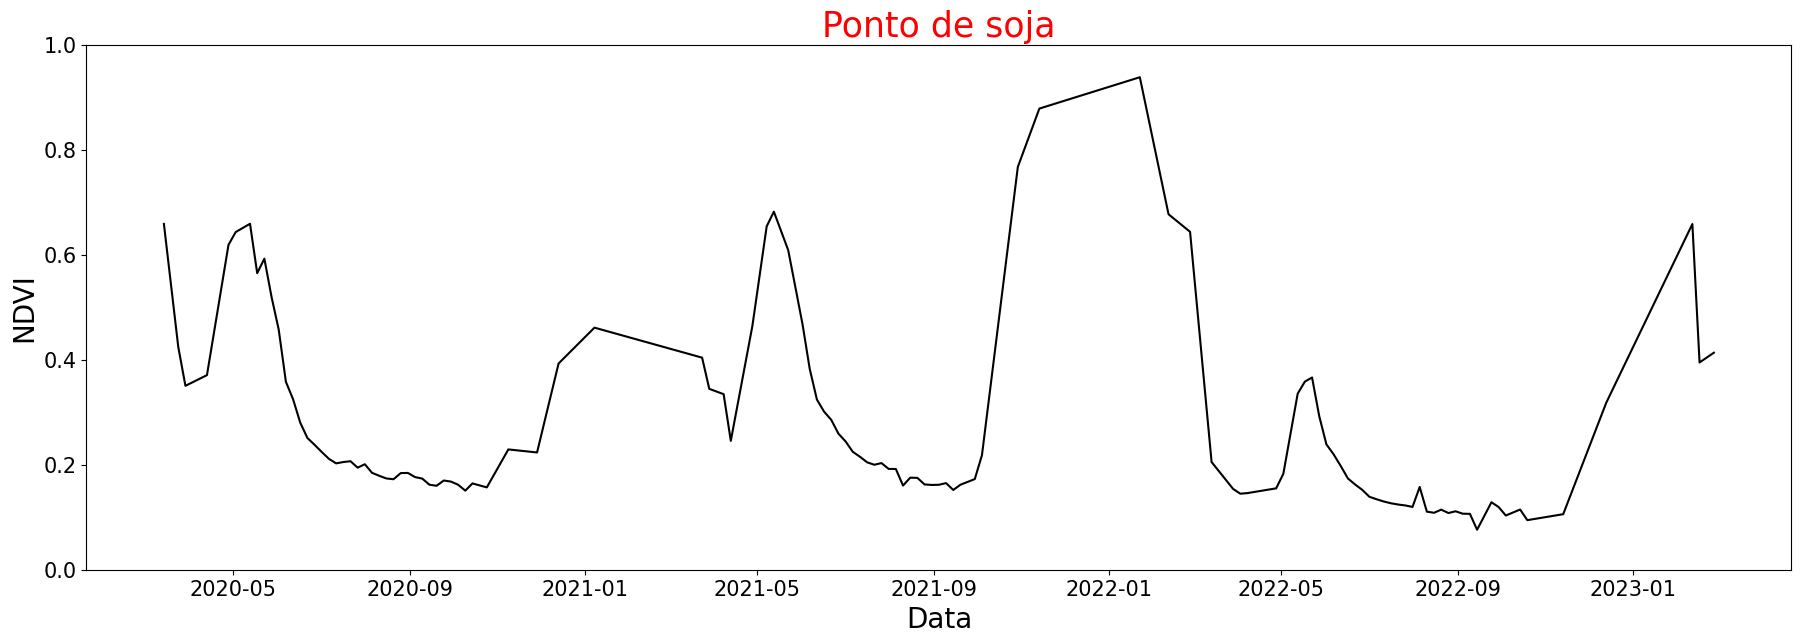

In [30]:
p, df_ndvi_evi, df_ndvi_evi_2023 = business.show_ndvi_timeseries(lat_long, CAR, start_date, end_date)
p

In [31]:
df_temp_atual, df_temp_hist = business.show_temperature_data(CAR, lat_long, 55660)

In [32]:
df_sms_atual, df_sms_hist = business.show_soilmoisture_data(CAR, lat_long)

<AxesSubplot:xlabel='Mês', ylabel='EVI'>

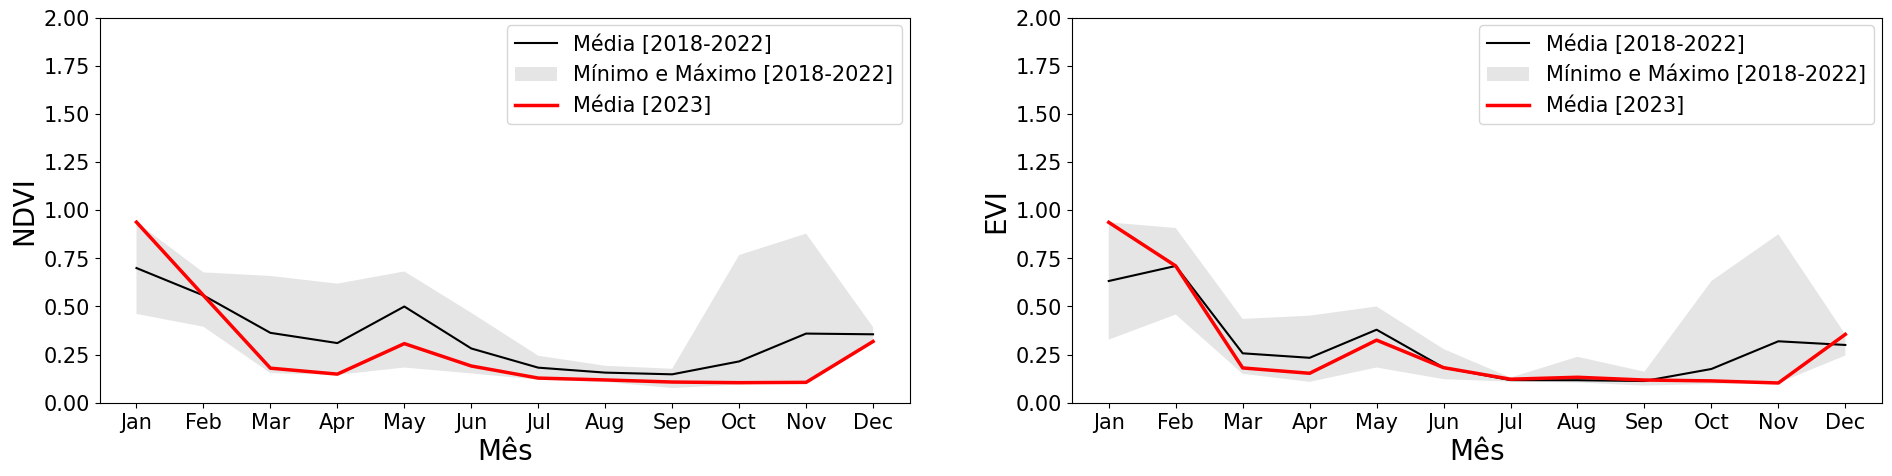

In [33]:
business.plot_ndvi_evi_ts(df_ndvi_evi, df_ndvi_evi_2023)

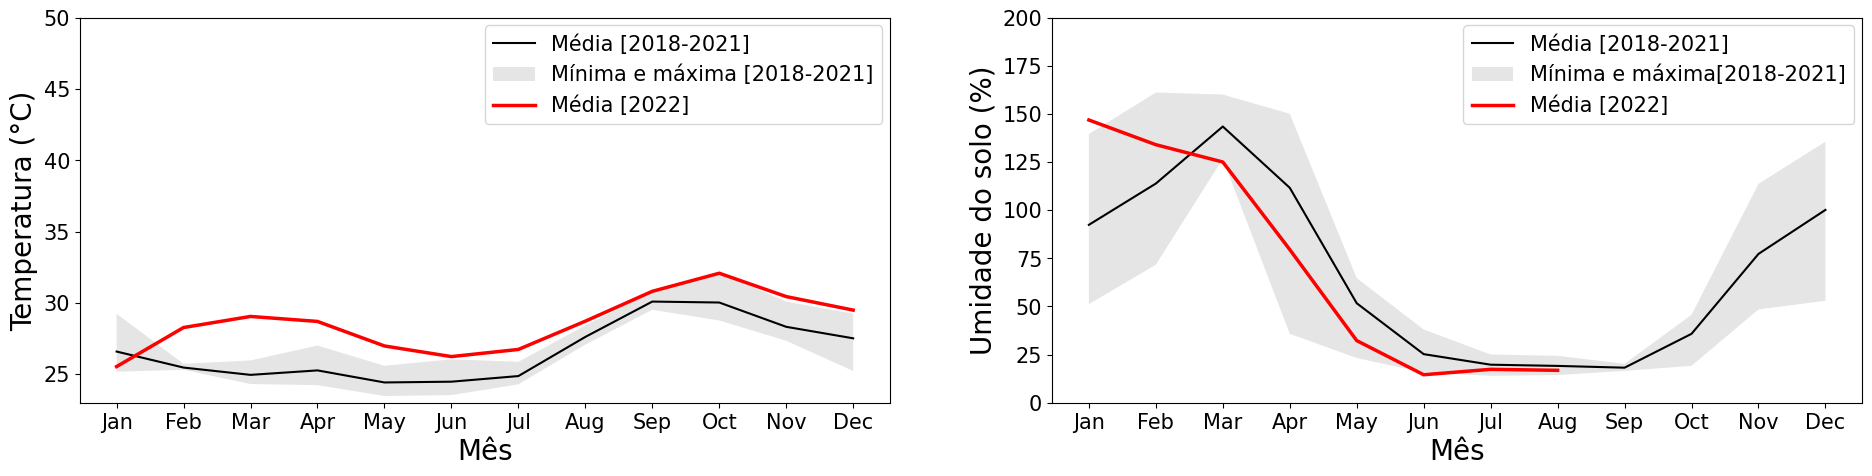

In [34]:
business.multi_plot_temp_sms(df_temp_hist, df_temp_atual, df_sms_hist, df_sms_atual)

In [35]:
df_ppt = business.show_precipitation_data(CAR, lat_long)

<AxesSubplot:xlabel='Mês', ylabel='Precipitação acumulada (mm)'>

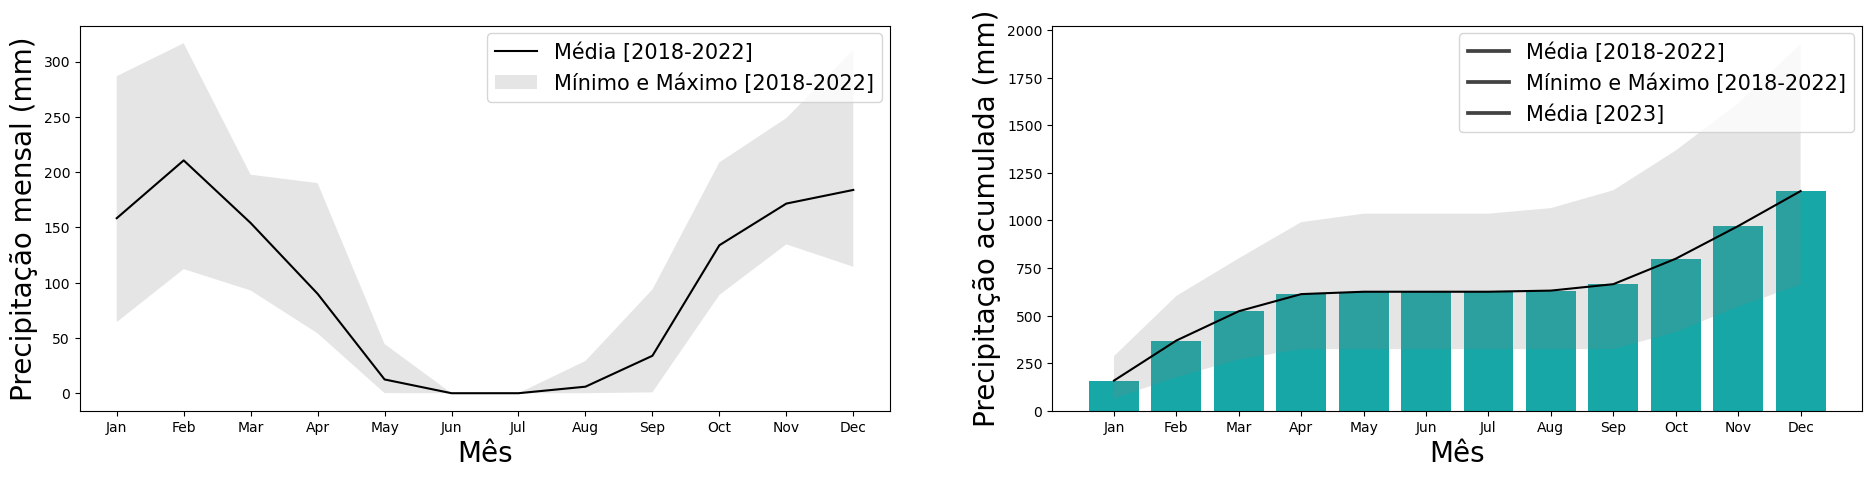

In [36]:
business.multi_plot_precipitation(df_ppt)